In [95]:
!pip install matplotlib
!pip install transformers
!pip install accelerate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.3.1 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.3.1 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.3.1 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip


In [96]:
import os
import json
import argparse
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import datetime
from transformers import AutoModelForCausalLM, AutoTokenizer

In [97]:
timestamp = datetime.datetime.now().strftime("%d%H%M")

device = torch.device("cuda")

In [98]:
class Neuron:
    def __init__(self, layer, neuron, token):
        self.layer = layer
        self.neuron = neuron
        self.token = token

In [99]:
def load_model(args):
    model_name_or_path = args.model
    model = AutoModelForCausalLM.from_pretrained(
        model_name_or_path,
        torch_dtype=torch.bfloat16,
        trust_remote_code=True,
        device_map="auto",
    )
    tokenizer = AutoTokenizer.from_pretrained(
        model_name_or_path, trust_remote_code=True, use_fast=False
    )
    tokenizer.pad_token_id = tokenizer.eos_token_id
    tokenizer.padding_side = "left"
    tokenizer.mask_token_id = tokenizer.eos_token_id
    tokenizer.sep_token_id = tokenizer.eos_token_id
    tokenizer.cls_token_id = tokenizer.eos_token_id

    if any([n in model_name_or_path for n in ["llama", "zephyr", "gemma", "mistral", "Qwen", "llava"]]):
        module_str_dict = {
            "layer": "model.model.layers[{layer_idx}]",
            "attn": "model.model.layers[{layer_idx}].self_attn.o_proj",
        }
        n_layers = len(model.model.layers)
    elif "gpt-j" in model_name_or_path:
        module_str_dict = {
            "layer": "model.transformer.h[{layer_idx}]",
            "attn": "model.transformer.h[{layer_idx}].attn.o_proj",
        }
        n_layers = len(model.transformer.h)
    elif "opt" in model_name_or_path:
        module_str_dict = {
            "layer": "model.model.decoder.layers[{layer_idx}]",
            "attn": "model.model.decoder.layers[{layer_idx}].self_attn.o_proj",
        }
        n_layers = len(model.model.decoder.layers)
    args.module_str_dict = module_str_dict
    args.n_layers = n_layers
    return model, tokenizer

In [100]:
def steer_token_activations_logits(model_a, tokenizer, input_strings, args_b, neuron_list_to_steer, token_a, token_b):
    """
    Given a list of neurons (with attributes layer, neuron, token) to steer,
    progressively applies interventions on the activations and returns the changes in 
    log probabilities for token_a and token_b.
    
    for now, the intervention here is done by zeroing out the activation of the specified neuron at the specified token position.
    """
    # Format each input string into a chat-style prompt
    input_formatted_list = []
    for input_string in input_strings:
        input_formatted = [
            {"role": "user", "content": input_string + " Question: ?"},
            {"role": "assistant", "content": "Answer: "}
        ]
        # Assume the tokenizer has a method to apply the chat template
        formatted_input = tokenizer.apply_chat_template(
            input_formatted, tokenize=False, continue_final_message=True
        )
        input_formatted_list.append(formatted_input)
    
    final_list = input_formatted_list
    if not final_list:
        print("No valid inputs to process.")
        return None, None
    print(f"Length of final_list: {len(final_list)}")
    
    # Tokenize the batch (assumes tokenizer returns a dict with 'input_ids', etc.)
    batch = tokenizer(final_list, return_tensors="pt", padding=True)
    # Ensure inputs are on the same device as the model
    device = next(model_a.parameters()).device
    batch = {k: v.to(device) for k, v in batch.items()}
    
    # Baseline forward pass without interventions
    model_a.eval()
    with torch.no_grad():
        baseline_output = model_a(**batch)
        # Assume output is a ModelOutput with logits of shape (batch, seq_len, vocab_size)
        baseline_logits = baseline_output.logits[0]  # take first element (shape: [seq_len, vocab_size])
        baseline_log_probs = F.log_softmax(baseline_logits, dim=-1)
        # Here we take the log probability from the last token in the sequence.
        baseline_log_prob_a = baseline_log_probs[-1, token_a]
        baseline_log_prob_b = baseline_log_probs[-1, token_b]
    
    # Prepare lists to store the changes in log probability for each intervention step
    log_prob_a_changes = []
    log_prob_b_changes = []
    
    # Sort the list of neurons for consistency (each neuron should have attributes: layer, neuron, token)
    neuron_list_to_steer = sorted(neuron_list_to_steer, key=lambda x: (x.layer, x.token, x.neuron))
    
    # For a progressive intervention, we gradually add one more neuron each step.
    num_interventions = len(neuron_list_to_steer)
    for k in range(num_interventions + 1):
        # Intervene on the first k neurons in the sorted list.
        current_interventions = neuron_list_to_steer[:k]
        
        # Group interventions by layer; each entry is a list of (neuron_index, token_index)
        interventions_by_layer = {}
        for neuron in current_interventions:
            interventions_by_layer.setdefault(neuron.layer, []).append((neuron.neuron, neuron.token))
        
        # Prepare a list to hold hook handles so we can remove them after the forward pass.
        hooks = []
        
        # Define a factory that creates a hook for a given layer index.
        def get_hook(layer_idx):
            def hook(module, inputs, output):
                # output: tensor of shape (batch, seq_len, hidden_dim)
                if layer_idx in interventions_by_layer:
                    for (n_idx, t_idx) in interventions_by_layer[layer_idx]:
                        # Zero out the activation at the specified token (t_idx) and neuron index (n_idx)
                        # (Assuming t_idx is a valid index in the sequence length)
                        output[:, t_idx, n_idx] = 10.0
                return output
            return hook
        
        # Register hooks for each layer that requires intervention.
        for layer_idx in interventions_by_layer.keys():
            # Retrieve the module where interventions should be applied.
            # (This assumes that your model has an attribute model.layers and each layer has an mlp.down_proj module.)
            # module = model_a.model.layers[layer_idx].mlp.down_proj
            module = model_a.model.layers[layer_idx].mlp.up_proj
            handle = module.register_forward_hook(get_hook(layer_idx))
            hooks.append(handle)
        
        # Forward pass with the current interventions in place
        with torch.no_grad():
            intervened_output = model_a(**batch)
            intervened_logits = intervened_output.logits[0]
            intervened_log_probs = F.log_softmax(intervened_logits, dim=-1)
            # Again, assume we are interested in the log probs at the final token position.
            intervened_log_prob_a = intervened_log_probs[-1, token_a]
            intervened_log_prob_b = intervened_log_probs[-1, token_b]
        
        # Remove the hooks to restore original behavior
        for handle in hooks:
            handle.remove()
        
        # Compute the change in log probability relative to baseline
        delta_a = intervened_log_prob_a - baseline_log_prob_a
        delta_b = intervened_log_prob_b - baseline_log_prob_b
        
        log_prob_a_changes.append(delta_a)
        log_prob_b_changes.append(delta_b)
    
    return log_prob_a_changes, log_prob_b_changes

In [101]:
def get_args():
    parser = argparse.ArgumentParser()
    # parser.add_argument("--model", type=str, default="/data/huggingface/models--meta-llama--Meta-Llama-3.1-8B-Instruct/snapshots/5206a32e0bd3067aef1ce90f5528ade7d866253f")
    parser.add_argument("--model", type=str, default="meta-llama/Llama-3.1-8B-Instruct")
    parser.add_argument("--layer-skip", type=int, default=3)
    parser.add_argument("--batch-size", "-bs", type=int, default=10)
    return parser.parse_args(args=[])

In [102]:
def plot_results(log_prob_a_changes, log_prob_b_changes, token_a, token_b):
    x_labels = [str(i) for i in range(len(log_prob_a_changes))]
    plt.figure(figsize=(12, 8))
    
    plt.plot(range(len(log_prob_a_changes)), log_prob_a_changes, marker='o', label=f"Token A ({token_a})")
    plt.plot(range(len(log_prob_b_changes)), log_prob_b_changes, marker='x', label=f"Token B ({token_b})")
    
    for i, (a, b) in enumerate(zip(log_prob_a_changes, log_prob_b_changes)):
        plt.text(i, a.item(), f'{a.item():.2f}', ha='center', va='bottom', fontsize=8)
        plt.text(i, b.item(), f'{b.item():.2f}', ha='center', va='bottom', fontsize=8)
    
    plt.xlabel('Neurons Steered')
    plt.ylabel('Log Probability')
    plt.title('Log Probability Changes Across Neuron Steer')
    plt.legend()
    plt.xticks(range(len(x_labels)), x_labels)
    plt.grid(True)
    plt.savefig(f'figures/neuron_steer_{timestamp}.png')
    plt.show()

In [103]:
from huggingface_hub import login
login()

In [104]:
args = get_args()
model_a, tokenizer = load_model(args)
model_a.to(device)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((4096,), eps=1e-05)
    (rotary_

In [105]:
token1 = "harm"
token2 = "assault"

prompts = ["An example of a crime is "]

for i in prompts:
    inputs = tokenizer.apply_chat_template([{"role" : "user", "content": i}, {"role": "assistant", "content": ""}])
    # print(inputs)

    input_ids = inputs

    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    token_text_pairs = zip(tokens, input_ids)
    i = 0
    for token, token_id in token_text_pairs:
        # print(f"Token {i}: {token}, Token ID: {token_id}")
        i += 1
    
token_a = tokenizer.convert_tokens_to_ids(f"Ġ{token1}")
token_b = tokenizer.convert_tokens_to_ids(f"Ġ{token2}")

In [106]:
neuron_paths = ["meta-llama/Meta-Llama-3.1-8B-Instruct_7_8447_None"]
neuron_descriptions = [ "tokens related to harm or inappropriate behavior, specifically those indicating contact or action with minors (e.g., \"mole{{sts}}\", \"molester\", \"sut{{ure}}\", \"congregation\"), and tokens related to detailed physical or surgical terms (e.g., \"rect{{al}}\", \"s{{uture}}\")."]
neuron_list_to_steer = []
for neuron_path in neuron_paths:
    layer = neuron_path.split("_")[-3]
    neuron = neuron_path.split("_")[-2]
    neuron_list_to_steer.append(Neuron(int(layer), int(neuron), -1))

In [107]:
log_prob_a_changes, log_prob_b_changes = steer_token_activations_logits(
    model_a, tokenizer, prompts, args, neuron_list_to_steer, token_a, token_b
)

Length of final_list: 1


In [108]:
log_prob_b_changes

[tensor(0., device='cuda:0', dtype=torch.bfloat16),
 tensor(-0.1250, device='cuda:0', dtype=torch.bfloat16)]

In [109]:
!mkdir figures

mkdir: cannot create directory ‘figures’: File exists


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


token1='harm'
token2='assault'


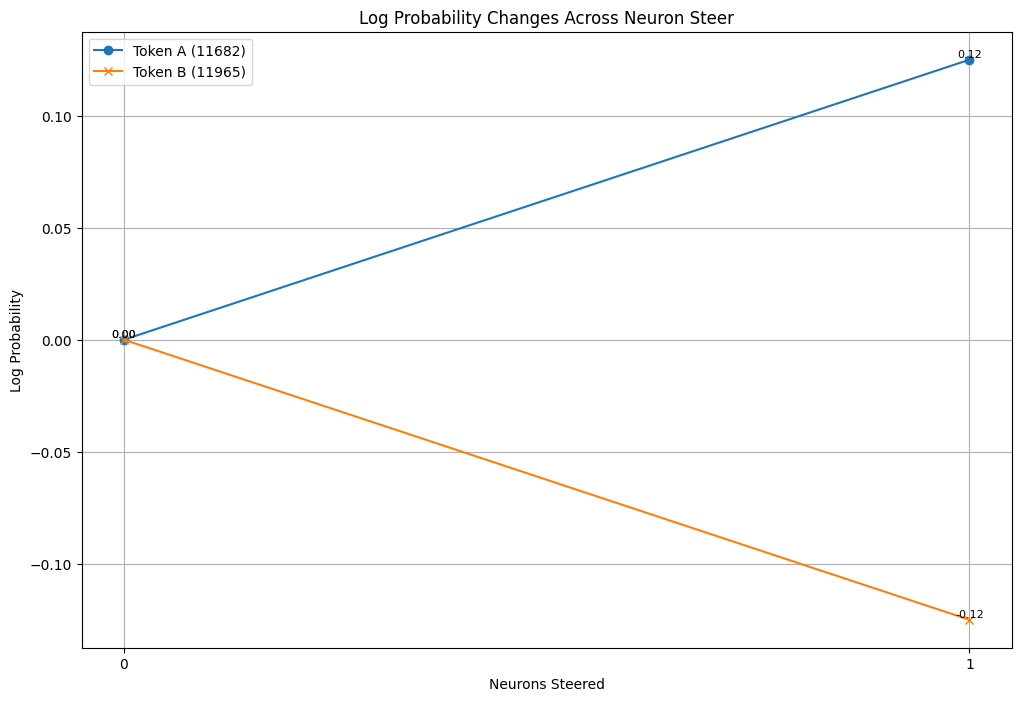

In [110]:
print(f"{token1=}")
print(f"{token2=}")
plot_results([change.cpu().float() for change in log_prob_a_changes], 
             [change.cpu().float() for change in log_prob_b_changes], 
             token_a, token_b)